In [1]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: Number of epochs with no improvement after which training will be stopped.
        :param min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [27]:
import os
import nibabel as nib
import nrrd
import monai
from monai.transforms import (Compose, LoadImaged, EnsureChannelFirstd, CenterSpatialCropd, RandRotate90d, ToTensord)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam



print("Initializing the dataset class...")

# class MyDataset(Dataset):
#     def __init__(self, data_dicts, transforms):
#         self.data_dicts = data_dicts
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.data_dicts)

#     def __getitem__(self, idx):
#         image_data, _ = nrrd.read(self.data_dicts[idx]['image'])
#         label_data, _ = nrrd.read(self.data_dicts[idx]['label'])

#         # Ensure that the data has a channel dimension
#         # If your data is single-channel (grayscale), add a new axis
#         image_data = image_data[None, ...]  # Adds a new axis at position 0
#         label_data = label_data[None, ...]  # Adds a new axis at position 0

#         return self.transforms({'image': image_data, 'label': label_data})


# class MyDataset(Dataset):
#     def __init__(self, data_dicts, transforms):
#         self.data_dicts = data_dicts
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.data_dicts)

#     def __getitem__(self, idx):
#         image_data, _ = nrrd.read(self.data_dicts[idx]['image'])
#         label_data, _ = nrrd.read(self.data_dicts[idx]['label'])

#         # Add a channel dimension if necessary
#         if len(image_data.shape) == 3:  # Assuming image_data is a 3D volume without a channel dimension
#             image_data = image_data[None, ...]  # Add a channel dimension
#         if len(label_data.shape) == 3:
#             label_data = label_data[None, ...]

#         return self.transforms({'image': image_data, 'label': label_data})



print("Defining the create_dataset function...")
# Function to create dataset
def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

print("Setting data paths...")
# Set data paths
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

print("Creating datasets...")
train_files = create_dataset(train_data_dir)
val_files = create_dataset(val_data_dir)

# Define the size of the cropped region
# roi_size = (128, 128, 128)
roi_size = (64, 64, 64)
print("Defining transformations...")
# Transformations
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),
    ToTensord(keys=['image', 'label']),
])
print("Initializing data loaders...")
# Data Loaders
train_ds = Dataset(train_files, train_transforms)
val_ds = Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)
print("Initializing U-Net model...")
# Model
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
print("Setting up loss function and optimizer...")
# Loss function and optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) ###############1
criterion = loss_function
optimizer = Adam(net.parameters(), 1e-3)


# Training step
def train_step(batch_data, model, loss_function, optimizer):
    # print("Reading in the images")
    images, labels = batch_data['image'], batch_data['label']
    optimizer.zero_grad()
    print("Passing Through the Network")
    outputs = model(images)
    loss = loss_function(outputs, labels)
    print("Loss Backward")
    loss.backward()
    print("Stepping Optimizer")
    optimizer.step()
    return loss.item(), outputs

# Visualization and saving function
def visualize_and_save(inputs, outputs, labels, iteration, epoch, base_folder="z:/W-People/Nate/Deep_Learning_Data"):
    # os.makedirs(folder, exist_ok=True)
    # md_file_path = os.path.join(folder, "visualization.md")
    # md_file = open(f"{md_file_path}/visualization.md", "a")

    folder = os.path.join(base_folder, "output_images")
    os.makedirs(folder, exist_ok=True)
    md_file_path = os.path.join(folder, "visualization.md")

    # slice_idx = inputs.shape[2] // 2
    # for i in range(inputs.shape[0]):
    #     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    #     ax[0].imshow(labels[i, 0, :, :, slice_idx], cmap="gray")
    #     ax[0].set_title("Ground Truth")
    #     ax[1].imshow(outputs[i, 0, :, :, slice_idx].detach().cpu(), cmap="gray")
    #     ax[1].set_title("Prediction")
    #     img_path = f"{folder}/iteration_{iteration}_batch_{i}.png"
    #     plt.savefig(img_path)
    #     plt.close()
    #     md_file.write(f"![Iteration {iteration} Batch {i}]({img_path})\n\n")
    # md_file.close()
    with open(md_file_path, "a") as md_file:
        slice_idx = inputs.shape[2] // 2
        for i in range(inputs.shape[0]):
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(labels[i, 0, :, :, slice_idx], cmap="gray")
            ax[0].set_title("Ground Truth")
            ax[1].imshow(outputs[i, 0, :, :, slice_idx].detach().cpu(), cmap="gray")
            ax[1].set_title("Prediction")
            # img_path = os.path.join(folder, f"Epoch-{epoch}_iteration-{iteration}_batch-{i}.png")
            img_path = r"Z:/W-People/Nate/Deep_Learning_Data/output_images/ABD.png"
            plt.savefig(img_path) #".\ABC.png"
            plt.close()
            md_file.write(f"![Epoch-{epoch} Iteration-{iteration} Batch-{i}]({img_path})\n\n")
        md_file.close()

    print(f"Markdown file updated at {md_file_path}")

# Loss Plotting Function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.draw()
    plt.pause(0.001)

# Main training loop
num_epochs = 3 # Example value
display_interval = 1 # Example value

train_losses = []
val_losses = []
print("Starting the training loop...")
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0

    # Training Phase
    net.train()
    print("\nReading in the first batch ..")
    for iteration, batch_data in enumerate(train_loader):
        print(f"Training Iteration: {iteration}")
        loss, output = train_step(batch_data, net, criterion, optimizer)
        epoch_train_loss += loss
        if iteration % display_interval == 0:
            visualize_and_save(batch_data['image'], output, batch_data['label'], iteration, epoch) ##########2
        print("\nReading in the next batch [if any] ..")

    train_losses.append(epoch_train_loss / len(train_loader))

    print("Running the validation loop ..")
    # Validation Phase
    net.eval()
    with torch.no_grad():
        print("Reading in the first batch ..")
        for batch_data in val_loader:
            images, labels = batch_data['image'], batch_data['label']
            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            print("\nReading in the next batch [if any] ..")
    
    val_losses.append(epoch_val_loss / len(val_loader))

    # Plot Losses
    print("Plotting losses ..")
    plot_losses(train_losses, val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.ioff()  # Turn off interactive mode
plt.show()  # Display final plots


model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet(NEWTRY).pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Nate_Unet_optimizer(NEWTRY).pth"

torch.save(net.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)


# Get Markdown working and maybe add the tensorboard thing
# Add the device to the 
# Deleting plot but just keep the same one everytime. 
# Getting parameters right and running 
# Running for 500 epochs (goal)
# Get this going tomorrow. 

Initializing the dataset class...
Defining the create_dataset function...
Setting data paths...
Creating datasets...
Defining transformations...
Initializing data loaders...
Initializing U-Net model...
Setting up loss function and optimizer...
Starting the training loop...

Reading in the first batch ..
Training Iteration: 0
Passing Through the Network
Loss Backward
Stepping Optimizer
Markdown file updated at z:/W-People/Nate/Deep_Learning_Data\output_images\visualization.md

Reading in the next batch [if any] ..
Training Iteration: 1
Passing Through the Network
Loss Backward
Stepping Optimizer
Markdown file updated at z:/W-People/Nate/Deep_Learning_Data\output_images\visualization.md

Reading in the next batch [if any] ..
Running the validation loop ..
Reading in the first batch ..

Reading in the next batch [if any] ..

Reading in the next batch [if any] ..


KeyboardInterrupt: 

In [ ]:
import os
import nibabel as nib
import monai
from monai.transforms import Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, RandSpatialCropd, ToTensord
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch

# Enable interactive mode for real-time loss plotting
plt.ion()

# Dataset class
# class MyDataset(Dataset):
#     def __init__(self, image_files, label_files, transforms):
#         self.image_files = image_files
#         self.label_files = label_files
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         image = nib.load(self.image_files[idx]).get_fdata()
#         label = nib.load(self.label_files[idx]).get_fdata()
#         data = {'image': image, 'label': label}
#         return self.transforms(data)

def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts


train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"



print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir) 


# Transformations
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
    ToTensord(keys=["image", "label"])
])

# Model
net = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

# Training step
def train_step(batch_data, model, loss_function, optimizer):
    images, labels = batch_data['image'], batch_data['label']
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), outputs

# Visualization and saving function
def visualize_and_save(inputs, outputs, labels, iteration, folder="output_images"):
    os.makedirs(folder, exist_ok=True)
    md_file = open(f"{folder}/visualization.md", "a")
    slice_idx = inputs.shape[2] // 2
    for i in range(inputs.shape[0]):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(labels[i, 0, :, :, slice_idx], cmap="gray")
        ax[0].set_title("Ground Truth")
        ax[1].imshow(outputs[i, 0, :, :, slice_idx].detach().cpu(), cmap="gray")
        ax[1].set_title("Prediction")
        img_path = f"{folder}/iteration_{iteration}_batch_{i}.png"
        plt.savefig(img_path)
        plt.close()
        md_file.write(f"![Iteration {iteration} Batch {i}]({img_path})\n\n")
    md_file.close()

# Loss Plotting Function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.draw()
    plt.pause(0.001)

# Main training loop
num_epochs = 10 # Example value
display_interval = 2 # Example value
# Define train_loader, val_loader, criterion, optimizer

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0

    # Training Phase
    net.train()
    for iteration, batch_data in enumerate(train_loader):
        loss, output = train_step(batch_data, net, criterion, optimizer)
        epoch_train_loss += loss
        if iteration % display_interval == 0:
            visualize_and_save(batch_data['image'], output, batch_data['label'], iteration)

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation Phase
    net.eval()
    with torch.no_grad():
        for batch_data in val_loader:
            images, labels = batch_data['image'], batch_data['label']
            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))

    # Plot Losses
    plot_losses(train_losses, val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.ioff()  # Turn off interactive mode
plt.show()  # Display final plots


In [2]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.handlers import StatsHandler, TensorBoardImageHandler
from monai.utils import set_determinism
from torch.utils.tensorboard import SummaryWriter

# Set determinism for reproducibility
set_determinism(seed=0)

# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel
print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size), # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) 

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) 

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_Unet.pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_Unet_optimzer.pth"
# Load the state dict into the model

if os.path.exists(model_save_path) and os.path.exists(optimizer_save_path):
    model.load_state_dict(torch.load(model_save_path))
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Loaded saved model and optimizer.")
else:
    print("No saved model or optimizer state found. Starting from scratch.")

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

# early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # You can adjust these parameters


print("Starting training process...")
num_epochs = 2
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
   


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # early_stopping(val_loss)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered")
    #     break


torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)
print(f"Model and optimizer states saved to {model_save_path} and {optimizer_save_path} respectively.")


# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Loaded saved model and optimizer.
Starting training process...


KeyboardInterrupt: 

Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
No saved model or optimizer state found. Starting from scratch.
Starting training process...
Epoch 1/2, Train Loss: 0.7975912392139435, Validation Loss: 0.7854490637779236
Epoch 2/2, Train Loss: 0.7706302106380463, Validation Loss: 0.7793985843658447
Model and optimizer states saved to z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_randomcrop_Unet.pth and z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_Unet_randomcrop_optimzer.pth respectively.
Plotting loss curves...


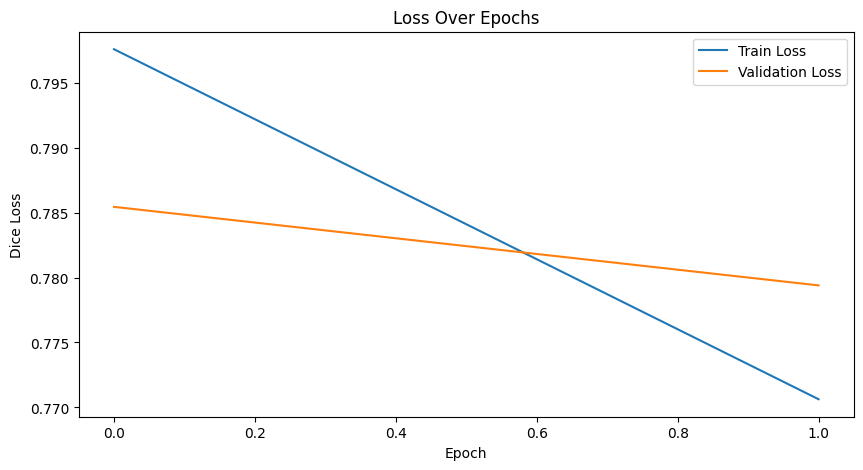

In [47]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd, RandSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.handlers import StatsHandler, TensorBoardImageHandler
from monai.utils import set_determinism
from torch.utils.tensorboard import SummaryWriter

# Set determinism for reproducibility
set_determinism(seed=0)

# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel
print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) # ScaleIntensityd(keys=['image', 'label'])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) # ScaleIntensityd(keys=['image', 'label'])

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 
model_save_path = "z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_randomcrop_Unet.pth"
optimizer_save_path = "z:/W-People/Nate/Deep_Learning_Data/Deep Learning Model/Nate_Unet_randomcrop_optimzer.pth"
# Load the state dict into the model

if os.path.exists(model_save_path) and os.path.exists(optimizer_save_path):
    model.load_state_dict(torch.load(model_save_path))
    optimizer.load_state_dict(torch.load(optimizer_save_path))
    print("Loaded saved model and optimizer.")
else:
    print("No saved model or optimizer state found. Starting from scratch.")

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # You can adjust these parameters


print("Starting training process...")
num_epochs = 2
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
   


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)
print(f"Model and optimizer states saved to {model_save_path} and {optimizer_save_path} respectively.")


# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Plotting loss curves...


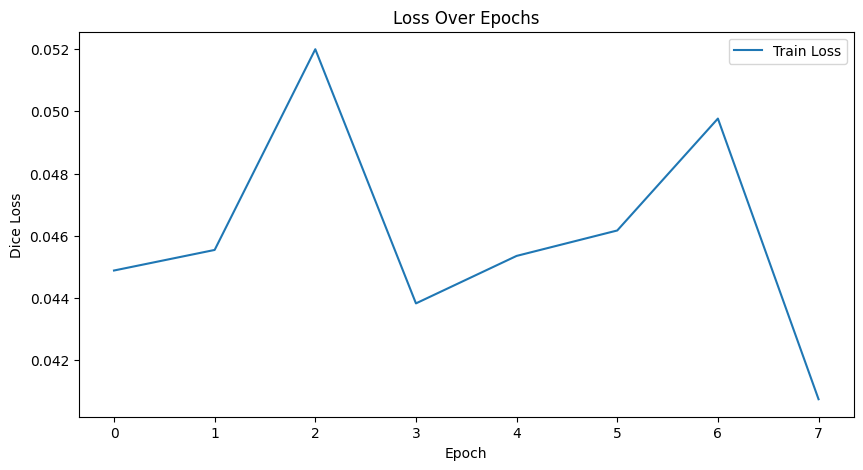

In [43]:
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()

In [1]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.handlers import StatsHandler, TensorBoardImageHandler
from monai.utils import set_determinism
from torch.utils.tensorboard import SummaryWriter

# Set determinism for reproducibility
set_determinism(seed=0)


# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) 

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) 

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

# writer = SummaryWriter()


def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

# stats_handler = StatsHandler(output_transform=lambda x: None)
# tb_image_handler = TensorBoardImageHandler(
#     log_dir='./runs/', batch_transform=lambda x: (x['image'], x['label']), output_transform=lambda x: x['pred']
# )

print("Starting training process...")
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
   
    # writer.add_scalar("Loss/Train", train_loss, epoch)
    # writer.add_scalar("Loss/Validation", val_loss, epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")


# writer.close()

# ADDING POIINT TO SAVE
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


Setting up directories and initial configurations...
Creating datasets...
Defining transformations...
Initializing 3D U-Net model...
Starting training process...


In [ ]:
# Gold standard with report and center cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, RandRotate90d, CenterSpatialCropd
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt



# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) 

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) 

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

print("Starting training process...")
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")



# ADDING POIINT TO SAVE
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


In [ ]:
# Gold standard random cropping

import os
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord, RandRotate90d
)
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from monai.data import pad_list_data_collate
from monai.transforms import Resized, SpatialPad
from monai.transforms import RandSpatialCropd 

# MONAI's transforms for dictionary format use 'd' at the end
# Assuming EnsureChannelFirstd is a valid replacement for AddChannel

print("Setting up directories and initial configurations...")


def create_dataset(data_dir):
    data_dicts = []
    for filename in os.listdir(data_dir):
        if filename.endswith("_Vx3.nrrd"):  # Identifies the image files
            image_path = os.path.join(data_dir, filename)
            label_filename = filename.replace("_Vx3.nrrd", "_Label.nrrd")  # Creates the label filename
            label_path = os.path.join(data_dir, label_filename)
            data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

# Set the paths for the training and validation data directories
train_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Train"
val_data_dir = "z:/W-People/Nate/Deep_Learning_Data/Validation"

# Desired sizes for cropping (not used in create_dataset but may be used elsewhere)
desired_height, desired_width, desired_depth = 128, 128, 128 

print("Creating datasets...")
train_files = create_dataset(train_data_dir)  # Only get files from the "Train" folder
val_files = create_dataset(val_data_dir)  

# Data Transformations
print("Defining transformations...")
roi_size = (desired_depth, desired_height, desired_width)  # Define the size of the cropped region
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=['image', 'label']),
]) # ScaleIntensityd(keys=['image', 'label'])

val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=roi_size),  # Use random cropping for validation as well
    ToTensord(keys=['image', 'label']),
]) # ScaleIntensityd(keys=['image', 'label'])

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_ds, batch_size=1) # collate_fn=pad_list_data_collate

# UNet Model Initialization

print("Initializing 3D U-Net model...")

model = UNet(
    spatial_dims=3,  # This specifies that the network should be 3D
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
)

# Loss Function and Optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #to_onehot_y=True,
optimizer = Adam(model.parameters(), 1e-3) # This is the learning rate 

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and Validation Functions
def train_epoch(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0
    for batch_data in loader:
        inputs, targets = batch_data['image'], batch_data['label']
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_data in loader:
            inputs, targets = batch_data['image'], batch_data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Main Training Loop
train_losses = []
val_losses = []

print("Starting training process...")
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")



# ADDING POIINT TO SAVE
# print("Visualizing transformed images...")
# plot_transformed_images(train_loader, num_images=1)

# Plotting loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()


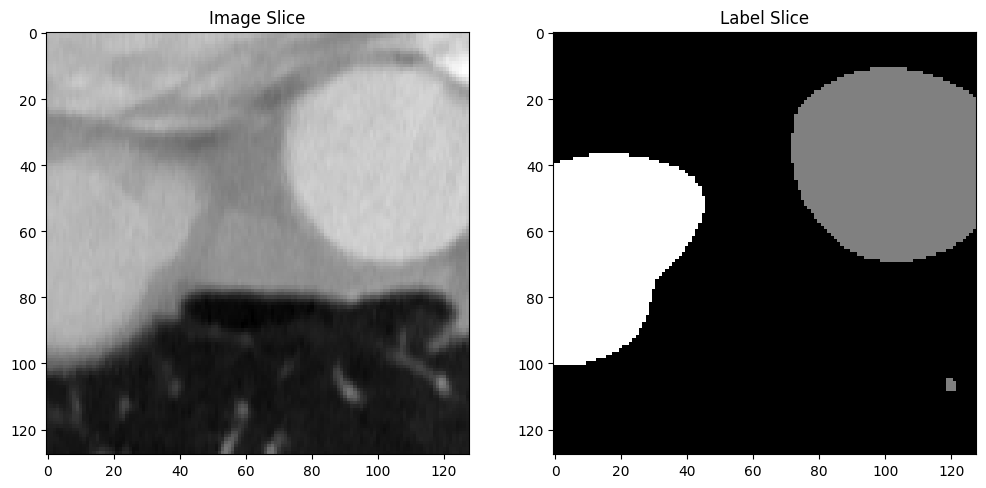

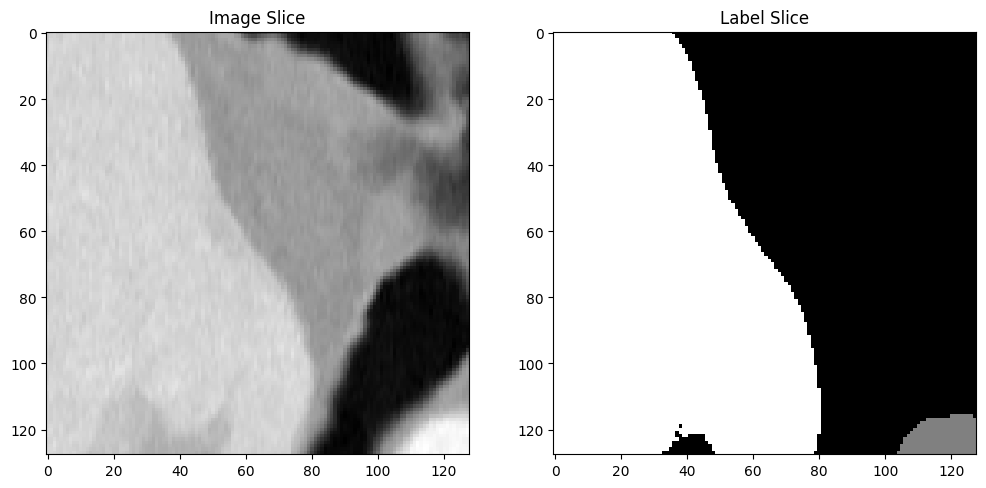

In [18]:
import numpy as np
def show_images(batch, slice_index=32, num_images=3):
    images, labels = batch['image'], batch['label']
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(12, 6))

        # Selecting a slice to display (e.g., the middle slice along the z-axis)
        image_slice = np.squeeze(images[i][0, slice_index, :, :])
        label_slice = np.squeeze(labels[i][0, slice_index, :, :])

        plt.subplot(1, 2, 1)
        plt.imshow(image_slice, cmap='gray')
        plt.title('Image Slice')

        plt.subplot(1, 2, 2)
        plt.imshow(label_slice, cmap='gray')
        plt.title('Label Slice')
        
        plt.show()

# Fetch a batch of data and show images
batch_data = next(iter(train_loader))
show_images(batch_data)


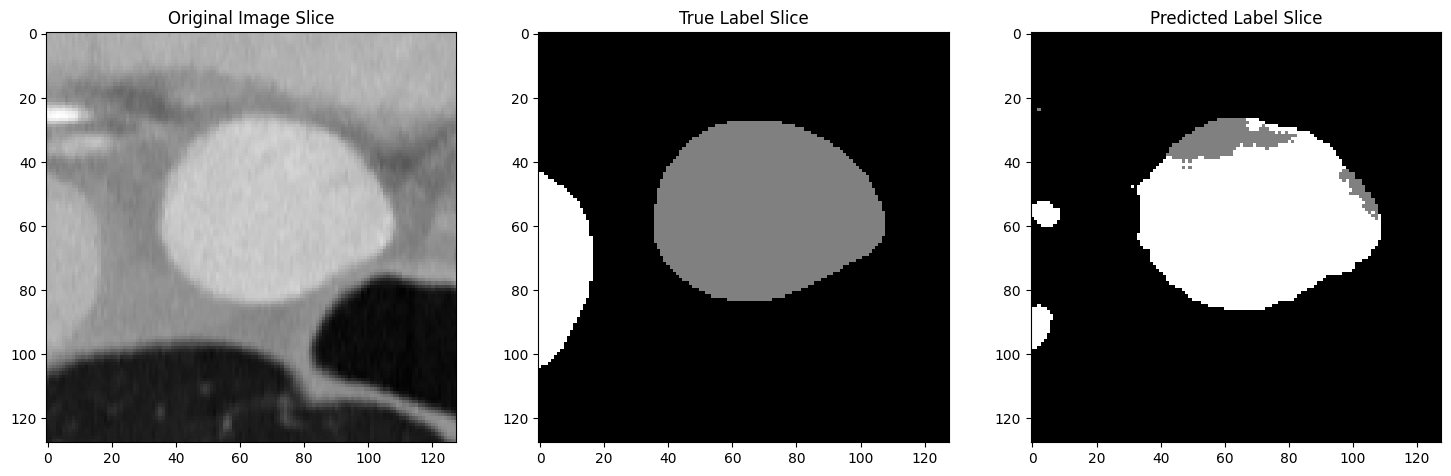

In [42]:
import numpy as np
def visualize_predictions(loader, model, device, num_images=3, slice_index=32):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_images, len(inputs))):
            plt.figure(figsize=(18, 6))

            # Selecting a slice to display
            input_slice = np.squeeze(inputs[i].cpu()[0, slice_index, :, :])
            target_slice = np.squeeze(targets[i].cpu()[0, slice_index, :, :])
            predicted_slice = np.squeeze(predicted_labels[i].cpu()[0, slice_index, :, :])

            plt.subplot(1, 3, 1)
            plt.imshow(input_slice, cmap='gray')
            plt.title('Original Image Slice')

            plt.subplot(1, 3, 2)
            plt.imshow(target_slice, cmap='gray')
            plt.title('True Label Slice')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_slice, cmap='gray')
            plt.title('Predicted Label Slice')

            plt.show()

visualize_predictions(val_loader, model, device)


In [2]:
def overlay_predictions(batch, predictions, alpha=0.3, num_images=3, slice_index=32):
    images, labels = batch['image'], batch['label']
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(8, 8))

        # Selecting a slice to display
        image_slice = np.squeeze(images[i][0, slice_index, :, :])
        prediction_slice = np.squeeze(predictions[i][0, slice_index, :, :])

        plt.imshow(image_slice, cmap='gray')
        plt.imshow(prediction_slice, cmap='winter', alpha=alpha)
        plt.title('Overlay of Prediction on Original Image Slice')
        plt.show()

# Create overlay visualizations
batch_data = next(iter(val_loader))
model.eval()
with torch.no_grad():
    inputs = batch_data['image'].to(device)
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=1, keepdim=True).cpu()
    overlay_predictions(batch_data, predicted_labels)


NameError: name 'val_loader' is not defined

In [ ]:
The 'colormap' trait of an IsoSurfaceFactory instance must be 'Accent' or 'Blues' or 'BrBG' or 'BuGn' or 'BuPu' or 'CMRmap' or 'Dark2' or 'GnBu' or 'Greens' or 'Greys' or 'OrRd' or 'Oranges' or 'PRGn' or 'Paired' or 'Pastel1' or 'Pastel2' or 'PiYG' or 'PuBu' or 'PuBuGn' or 'PuOr' or 'PuRd' or 'Purples' or 'RdBu' or 'RdGy' or 'RdPu' or 'RdYlBu' or 'RdYlGn' or 'Reds' or 'Set1' or 'Set2' or 'Set3' or 'Spectral' or 'Vega10' or 'Vega20' or 'Vega20b' or 'Vega20c' or 'Wistia' or 'YlGn' or 'YlGnBu' or 'YlOrBr' or 'YlOrRd' or 'afmhot' or 'autumn' or 'binary' or 'black-white' or 'blue-red' or 'bone' or 'brg' or 'bwr' or 'cool' or 'coolwarm' or 'copper' or 'cubehelix' or 'file' or 'flag' or 'gist_earth' or 'gist_gray' or 'gist_heat' or 'gist_ncar' or 'gist_rainbow' or 'gist_stern' or 'gist_yarg' or 'gnuplot' or 'gnuplot2' or 'gray' or 'hot' or 'hsv' or 'inferno' or 'jet' or 'magma' or 'nipy_spectral' or 'ocean' or 'pink' or 'plasma' or 'prism' or 'rainbow' or 'seismic' or 'spectral' or 'spring' or 'summer' or 'terrain' or 'viridis' or 'winter',

In [ ]:
# Problems to be fixed
# input volume should be ct image,,, when showing that in mayavi WHAT ARE YOU ACTUALLY SHOWING?
# do use contour 3d
# Add early stopping make epochs 200 
# first experiment add 5 images in validation train with two images
# try to get the best thing we can get just from two images first
# use the exact same 5 for validation
# ask chat gpt for creating a report (capabilities in monai)
# Change learning rate maybe add adaptive learning rate


In [ ]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Visualize original grayscale image volume
            # Adjust the visualization to correctly display the grayscale volume
            # The 'volume' function is used for volume rendering of scalar data
            mlab.pipeline.volume(mlab.pipeline.scalar_field(input_volume), figure=fig)

            # Visualize true label volume
            # Assuming target_volume contains discrete labels for segmentation
            mlab.contour3d(target_volume, contours=2, color=(0, 1, 0), transparent=True, figure=fig)

            # Visualize predicted label volume
            # Assuming predicted_volume contains discrete labels for segmentation
            mlab.contour3d(predicted_volume, contours=2, color=(1, 0, 0), transparent=True, figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)


In [13]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor = (0,0,0))

            # Visualize original image volume
            mlab.contour3d(input_volume, contours=[input_volume.max()/2], color=(0, 0, 1), transparent=True, figure=fig)

            # Visualize true label volume
            mlab.contour3d(target_volume, contours=[target_volume.max()/2], color=(0, 1, 0), transparent=True, figure=fig)

            # Visualize predicted label volume
            mlab.contour3d(predicted_volume, contours=[predicted_volume.max()/2], color=(1, 0, 0), transparent=True, figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)





In [7]:
from mayavi import mlab
import torch
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Visualize true label volume
            target_src = mlab.pipeline.scalar_field(target_volume)
            mlab.pipeline.iso_surface(target_src, contours=[target_volume.max() * 0.5], 
                                      colormap='winter', opacity=.5, figure=fig)

            # Visualize predicted label volume
            predicted_src = mlab.pipeline.scalar_field(predicted_volume)
            mlab.pipeline.iso_surface(predicted_src, contours=[predicted_volume.max() * 0.5], 
                                      colormap='rainbow', opacity=1, figure=fig)

            # Add legends and annotations
            mlab.text(0.01, 0.01, "Target Volume", color=(0, 0, 1), width=0.15, figure=fig)
            mlab.text(0.01, 0.95, "Predicted Volume", color=(1, 0, 0), width=0.15, figure=fig)

            # Display the visualization
            mlab.show()

# Assuming val_loader, model, and device have been defined elsewhere in your script:
visualize_predictions_3d(val_loader, model, device)


In [9]:
from mayavi import mlab
import numpy as np

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert model output to binary predictions
        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            # Reconstruct 3D volumes
            input_volume = inputs[i].cpu().squeeze().numpy()
            target_volume = targets[i].cpu().squeeze().numpy()
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy()

            target_volume = target_volume.astype(np.float32)
            predicted_volume = predicted_volume.astype(np.float32)

            # Set up a figure
            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Visualize original image volume
            # For better visualization, you may want to preprocess your volume
            # to set a threshold or adjust intensities.
            # input_volume_processed = preprocess_volume(input_volume)
            # mlab.pipeline.volume(mlab.pipeline.scalar_field(input_volume_processed), figure=fig)

            # Visualize true label volume
            true_volume_src = mlab.pipeline.scalar_field(target_volume)
            mlab.pipeline.volume(true_volume_src, vmin=0, vmax=target_volume.max(), figure=fig)

            # Visualize predicted label volume
            predicted_volume_src = mlab.pipeline.scalar_field(predicted_volume)
            mlab.pipeline.volume(predicted_volume_src, vmin=0, vmax=predicted_volume.max(), figure=fig)

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)


In [8]:
from mayavi import mlab
import numpy as np
import torch

def visualize_predictions_3d(loader, model, device, num_volumes=1):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        inputs, targets = batch['image'], batch['label']
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        predicted_labels = outputs.argmax(dim=1, keepdim=True)

        for i in range(min(num_volumes, len(inputs))):
            target_volume = targets[i].cpu().squeeze().numpy().astype(np.float32)  # Convert to float32
            predicted_volume = predicted_labels[i].cpu().squeeze().numpy().astype(np.float32)  # Convert to float32

            fig = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))

            # Volume rendering for target volume
            vol_target = mlab.pipeline.scalar_field(target_volume)
            target_volume_render = mlab.pipeline.volume(vol_target, figure=fig)
            target_volume_render.module_manager.scalar_lut_manager.lut.table = np.array([[0, 255, 0, v] for v in range(256)], 'float32')

            # Volume rendering for predicted volume
            vol_predicted = mlab.pipeline.scalar_field(predicted_volume)
            predicted_volume_render = mlab.pipeline.volume(vol_predicted, figure=fig)
            predicted_volume_render.module_manager.scalar_lut_manager.lut.table = np.array([[255, 0, 0, v] for v in range(256)], 'float32')

            # Display the visualization
            mlab.show()

# Call the function with appropriate parameters
visualize_predictions_3d(val_loader, model, device)


In [4]:
import monai.networks.nets as nets

# List all classes and functions in monai.networks.nets
print(dir(nets))

['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'Critic', 'DAF3D', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MultiModal', 'NetAdapter', 'PatchMerging', 'PatchMergingV2', 'Pooler', 'Quicknat', 'RegUNet', 'Regressor', 'ResNet', 'ResNetBlock', 'ResNetBottleneck', 'SENet', 'SENet154', 'SEResNeXt101', 'SEResNeXt50', 'SER

In [ ]:
import subprocess

def list_installed_packages(file_name):
    try:
        # Running 'pip list' command and capturing the output
        installed_packages = subprocess.check_output([sys.executable, '-m', 'pip', 'list'], universal_newlines=True)

        # Writing the output to a file
        with open(file_name, 'w') as file:
            file.write(installed_packages)

        print(f"List of installed packages written to {file_name}")
    except subprocess.CalledProcessError as e:
        print("An error occurred while retrieving the list of installed packages.")
        print(e)

if __name__ == "__main__":
    # Specify the name of the file where you want to save the list
    output_file = "installed_packages_Nate.txt"
    list_installed_packages(output_file)
